# Preparação e Filtros para fazer a contagens das bibs ao longo do tempo

O objetivo é analisar a evolução das dependências e devDependencies dos arquivos `package.json` em vários repositórios ao longo do tempo. O objetivo é gerar gráficos que mostram a evolução dessas dependências e realizar uma análise final sobre as bibliotecas utilizadas.

## Importação de Bibliotecas

- **pandas (`pd`)**: Para manipulação de dados em formato tabular.
- **matplotlib.pyplot (`plt`)**: Para visualização de gráficos.
- **collections**: Para interagir com a API do GitHub.
- **os**: Para interagir com o sistema operacional, como criação de diretórios.
- **collections**: Contar ocorrências e a biblioteca
- **ast**: 

## Funcionalidades

1. **Carregamento de Dados**: O script carrega uma lista de repositórios a partir de um arquivo CSV e busca os arquivos CSV gerados anteriormente que contêm o histórico das alterações no `package.json`.

2. **Verificação de Arquivos**: Para cada repositório, verifica se o arquivo CSV correspondente existe e se contém as colunas necessárias.

3. **Análise de Mudanças**: 
   - Converte as mudanças em dependências e devDependencies de strings para dicionários.
   - Rastreia as bibliotecas adicionadas e removidas ao longo do tempo, atualizando conjuntos de dependências.

4. **Evolução das Dependências**: Armazena a evolução das dependências e devDependencies em um DataFrame, incluindo o número atual de cada tipo de dependência.

5. **Geração de Gráficos**: 
   - Gera gráficos que mostram a evolução das dependências ao longo do tempo e ao longo dos commits.
   - Salva os gráficos em diretórios específicos.

6. **Análise Final**: 
   - Calcula o total de dependências únicas e devDependencies únicas.
   - Identifica quais dependências estiveram sempre presentes em todos os commits.

7. **Salvamento dos Resultados**: Salva os resultados da análise final em um arquivo CSV.


In [3]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import os

# Caminho para a pasta de CSVs
csv_folder_path = '../Database/Questao3/Repositorios'

# Carregar a lista de repositórios do CSV
repos_list_csv = pd.read_csv('../Database/Resultados-Busca/repositories.csv')

# Supondo que a coluna com o nome dos repositórios seja 'repo_name'
# Substituir '/' por '_' e adicionar o sufixo para coincidir com o padrão dos arquivos
repos_list = {repo.replace("/", "_") + "_package_json_history" for repo in repos_list_csv['name'].tolist()}

# Obter a lista de arquivos na pasta de CSVs (removendo a extensão .csv)
generated_csvs = {os.path.splitext(file)[0] for file in os.listdir(csv_folder_path) if file.endswith('.csv')}
repositorios_list = list(generated_csvs)
# Substituindo "_package_json_history" e "_" por "/" em cada elemento da lista
repositorios_list_modified = [repo.replace("_package_json_history", "").replace("_", "/") for repo in repositorios_list]

# Lista para armazenar dados de análise final
final_analysis_data = []

# Função para salvar o gráfico
def save_plot(x, y1, y2, x_label, title, filename, plot_type):
    plt.figure(figsize=(14, 7))
    plt.plot(x, y1, label='Dependências', marker='o', color='blue', markersize=8)
    plt.plot(x, y2, label='DevDependências', marker='o', color='orange', markersize=8)

    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel('Número de Dependências', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True, framealpha=1, edgecolor='black', facecolor='white')
    plt.tight_layout()

    # Definir o diretório de salvamento com base no tipo de gráfico
    if plot_type == 'date':
        save_path = "../Image/Questao3/Date"
    elif plot_type == 'commit':
        save_path = "../Image/Questao3/Commit"
    else:
        raise ValueError("Tipo de gráfico inválido. Use 'date' ou 'commit'.")

    os.makedirs(save_path, exist_ok=True)  # Cria o diretório se não existir
    plt.savefig(f"{save_path}/{filename}.png")
    plt.close()  # Fecha a figura para liberar memória

# Iterar sobre cada repositório listado
for i in range(len(repositorios_list)):  # Garante que não ultrapasse o tamanho da lista
    repo_name = repositorios_list[i]
    name = repositorios_list_modified[i]
    # Carregar os dados
    path = f'{csv_folder_path}/{repo_name}.csv'

    if not os.path.exists(path):
        print(f"Arquivo não encontrado: {path}")
        continue  # Pula para o próximo repositório se o arquivo não existir

    df = pd.read_csv(path)

    # Verificar se as colunas necessárias existem
    if not all(col in df.columns for col in ['date', 'commit', 'dependencies_changes', 'dev_dependencies_changes']):
        print(f"Colunas necessárias ausentes no arquivo: {repo_name}.csv")
        continue

    # Converter a coluna 'date' para o tipo datetime
    df['date'] = pd.to_datetime(df['date'])

    # Criar conjuntos para rastrear todas as bibliotecas
    all_dependencies = set()
    all_dev_dependencies = set()

    # Criar um DataFrame para armazenar a evolução
    evolution_data = []

    # Função para converter string em dicionário com tratamento de exceção
    def safe_literal_eval(s):
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError):
            return {'added': [], 'removed': []}

    df['dependencies_changes'] = df['dependencies_changes'].apply(safe_literal_eval)
    df['dev_dependencies_changes'] = df['dev_dependencies_changes'].apply(safe_literal_eval)

    # Iterar sobre as mudanças
    for index, data_row in df.iterrows():
        # Adicionando mudanças de dependências
        dependencies_added = data_row['dependencies_changes'].get('added', [])
        dependencies_removed = data_row['dependencies_changes'].get('removed', [])

        dev_dependencies_added = data_row['dev_dependencies_changes'].get('added', [])
        dev_dependencies_removed = data_row['dev_dependencies_changes'].get('removed', [])

        # Atualizar conjuntos de bibliotecas
        all_dependencies.update(dependencies_added)
        all_dependencies.difference_update(dependencies_removed)

        all_dev_dependencies.update(dev_dependencies_added)
        all_dev_dependencies.difference_update(dev_dependencies_removed)

        # Armazenar evolução
        evolution_data.append({
            'commit': data_row['commit'],
            'date': data_row['date'],
            'current_dependencies': list(all_dependencies),
            'current_dev_dependencies': list(all_dev_dependencies),
            'current_dependencies_count': len(all_dependencies),
            'current_dev_dependencies_count': len(all_dev_dependencies),
        })

    # Criar DataFrame de evolução
    evolution_df = pd.DataFrame(evolution_data)

    # Gráfico da evolução das dependências ao longo do tempo
    save_plot(evolution_df['date'], evolution_df['current_dependencies_count'], evolution_df['current_dev_dependencies_count'],
              'Data', f'Evolução das Dependências e DevDependências ao longo do Tempo - ({name})', f'{repo_name}_evolucao_dependencias_tempo', 'date')

    # Gráfico da evolução das dependências ao longo dos commits
    save_plot(evolution_df['commit'], evolution_df['current_dependencies_count'], evolution_df['current_dev_dependencies_count'],
              'Commits', f'Evolução das Dependências e DevDependências ao longo dos Commits - ({name})', f'{repo_name}_evolucao_dependencias_commits', 'commit')

    # Análise final
    total_unique_dependencies = len(all_dependencies)
    total_unique_dev_dependencies = len(all_dev_dependencies)

    print(f'Total de dependências únicas: {total_unique_dependencies}')
    print(f'Total de devDependências únicas: {total_unique_dev_dependencies}')

    # Verificar se as mesmas bibliotecas estiveram presentes sempre
    if not evolution_df['current_dependencies'].empty:
        always_present_dependencies = set.intersection(*(set(x) for x in evolution_df['current_dependencies']))
    else:
        always_present_dependencies = set()

    if not evolution_df['current_dev_dependencies'].empty:
        always_present_dev_dependencies = set.intersection(*(set(x) for x in evolution_df['current_dev_dependencies']))
    else:
        always_present_dev_dependencies = set()

    print(f'Dependências sempre presentes: {always_present_dependencies}')
    print(f'DevDependências sempre presentes: {always_present_dev_dependencies}')

    # Armazenar dados de análise final
    final_analysis_data.append({
        'repo_name': repo_name,
        'total_unique_dependencies': total_unique_dependencies,
        'total_unique_dev_dependencies': total_unique_dev_dependencies,
        'always_present_dependencies': ', '.join(always_present_dependencies),
        'always_present_dev_dependencies': ', '.join(always_present_dev_dependencies)
    })


# Criar um DataFrame com os dados de análise final
final_analysis_df = pd.DataFrame(final_analysis_data)

# Salvar o DataFrame como um arquivo CSV
final_analysis_df.to_csv('../Database/Questao3/final_analysis.csv', index=False)

Total de dependências únicas: 7
Total de devDependências únicas: 5
Dependências sempre presentes: {'react', 'react-native'}
DevDependências sempre presentes: set()
Total de dependências únicas: 0
Total de devDependências únicas: 44
Dependências sempre presentes: set()
DevDependências sempre presentes: set()
Total de dependências únicas: 20
Total de devDependências únicas: 29
Dependências sempre presentes: set()
DevDependências sempre presentes: {'style-loader', 'rucksack-css', 'sass-loader', 'autoprefixer'}
Total de dependências únicas: 12
Total de devDependências únicas: 17
Dependências sempre presentes: {'assets', 'recorder.js', 'main.js', 'recorderjs', 'stats.js', 'main', 'recorder', 'dat.gui', 'howler'}
DevDependências sempre presentes: {'babel-preset-env', 'webpack-cli', 'eslint', 'babel-preset-react', 'clang-format', 'cross-env', 'eslint-config-google', 'babel-preset-es2015', '@tensorflow-models/posenet', 'babel-polyfill', 'babel-preset-es2017', 'parcel-bundler', 'babel-core', 'd

C:\Users\tochi\AppData\Local\Temp\ipykernel_6260\376146471.py:69: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


Total de dependências únicas: 5
Total de devDependências únicas: 36
Dependências sempre presentes: set()
DevDependências sempre presentes: {'react', 'react-test-renderer', 'react-dom', 'enzyme-to-json', 'react-scripts', 'enzyme'}
Total de dependências únicas: 0
Total de devDependências únicas: 31
Dependências sempre presentes: set()
DevDependências sempre presentes: {'@testing-library/dom', 'inquirer', 'prettier-plugin-tailwindcss', '@commitlint/cli', 'solid-js', '@commitlint/cz-commitlint', 'vite', 'typescript', 'turbo', 'babel-preset-solid', 'prettier', '@commitlint/config-conventional', '@babel/core', 'vite-plugin-solid', 'commitizen', '@babel/preset-env', '@testing-library/user-event', '@types/node', '@changesets/cli', '@testing-library/jest-dom'}
Total de dependências únicas: 1
Total de devDependências únicas: 49
Dependências sempre presentes: set()
DevDependências sempre presentes: {'typescript'}
Total de dependências únicas: 25
Total de devDependências únicas: 28
Dependências se

# Síntese dos Dados

Realizar a análise inicial de um conjunto de dados sobre dependências de projetos UI. O objetivo é responder a terceira questão de pesquisa relacionadas às dependências mais comuns, à relação entre o número de dependências e características dos projetos, e à consistência das dependências ao longo do tempo.

## Funcionalidades

1. **Carregamento de Dados**: O script carrega um arquivo CSV contendo a análise final das dependências dos projetos.

2. **Identificação de Dependências Comuns**:
   - Conta a ocorrência de cada dependência listada na coluna `always_present_dependencies`.
   - Obtém as 20 dependências mais comuns entre os projetos UI.
   - Realiza o mesmo processo para as dependências de desenvolvimento (`always_present_dev_dependencies`).

3. **Análise Estatística**:
   - Calcula estatísticas descritivas para o total de dependências e dependências de desenvolvimento, utilizando essas métricas como proxy para o tamanho do projeto.

4. **Verificação de Consistência**:
   - Conta o número de valores não nulos nas colunas `always_present_dependencies` e `always_present_dev_dependencies` para verificar a consistência das dependências ao longo dos commits.

5. **Resultados**: O script retorna as dependências mais comuns, as dependências de desenvolvimento mais comuns, as estatísticas descritivas das dependências e as contagens de consistência.

Gráficos gerados com sucesso!


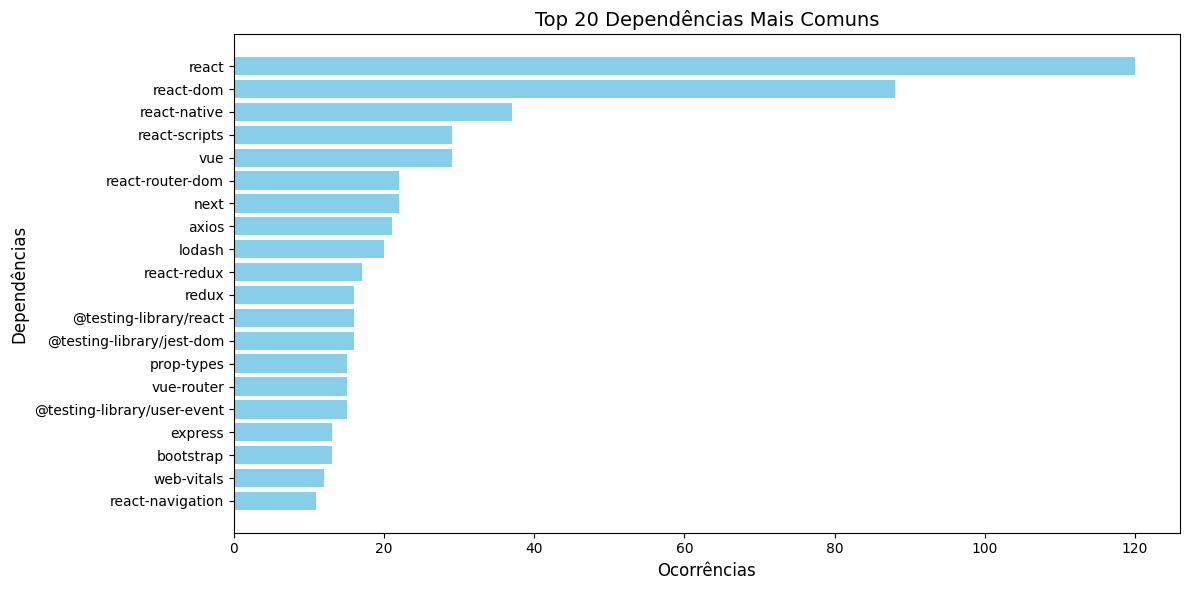

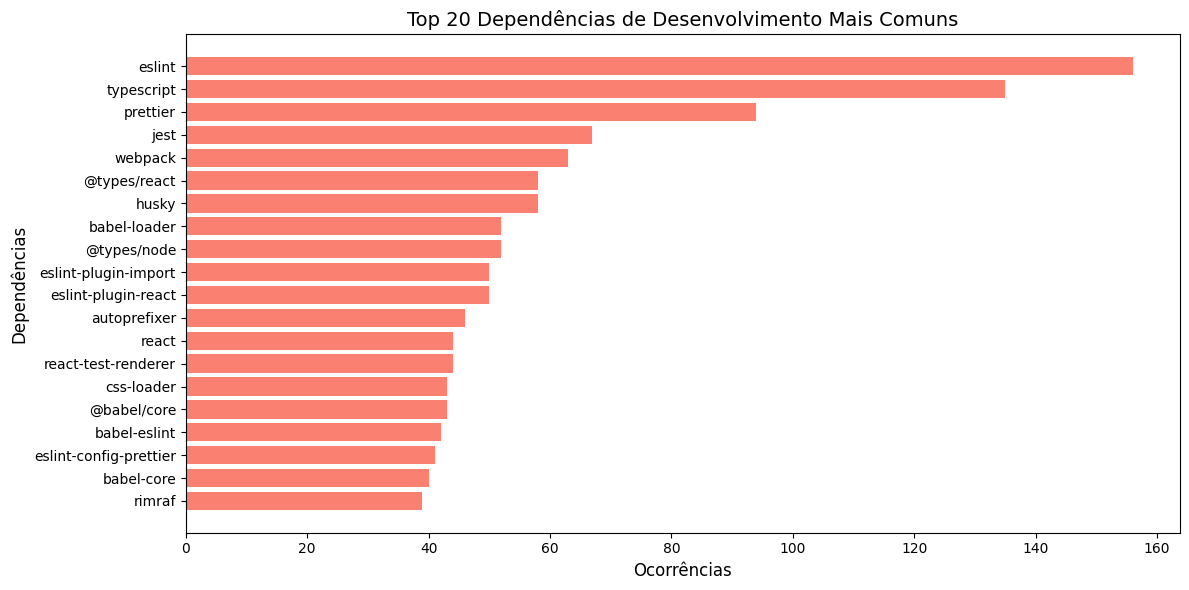

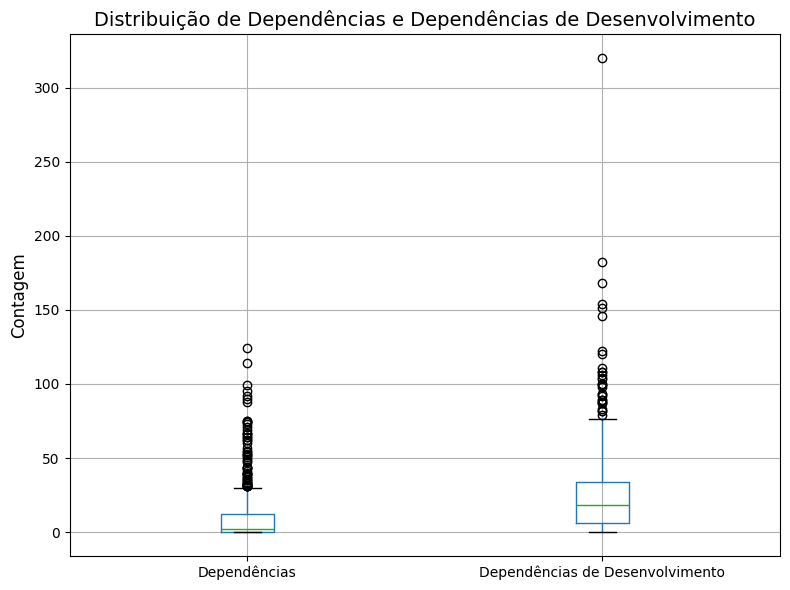

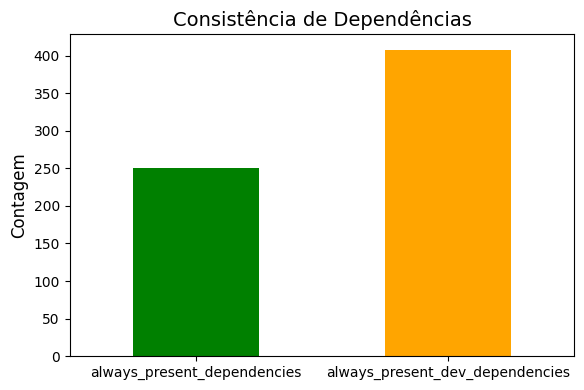

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# Caminho para o arquivo CSV
file_path = '../Database/Questao3/final_analysis.csv'

# Carregar os dados do CSV
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Arquivo não encontrado: {file_path}")
    exit()

# 1. Dependências mais comuns
# Processar as colunas de dependências e contar ocorrências
if 'always_present_dependencies' in data.columns:
    all_dependencies = data['always_present_dependencies'].dropna().str.split(',').sum()
    dependency_counts = Counter([dep.strip() for dep in all_dependencies])
    most_common_dependencies = dependency_counts.most_common(20)
else:
    most_common_dependencies = []

if 'always_present_dev_dependencies' in data.columns:
    all_devdependencies = data['always_present_dev_dependencies'].dropna().str.split(',').sum()
    devdependency_counts = Counter([dep.strip() for dep in all_devdependencies])
    most_common_devdependencies = devdependency_counts.most_common(20)
else:
    most_common_devdependencies = []

# 2. Estatísticas descritivas
if {'total_unique_dependencies', 'total_unique_dev_dependencies'}.issubset(data.columns):
    total_dependencies_stats = data[['total_unique_dependencies', 'total_unique_dev_dependencies']].describe()
else:
    total_dependencies_stats = None

# 3. Consistência das dependências
if {'always_present_dependencies', 'always_present_dev_dependencies'}.issubset(data.columns):
    consistency_counts = data[['always_present_dependencies', 'always_present_dev_dependencies']].notnull().sum()
else:
    consistency_counts = None

# Criar gráficos
output_dir = '../Image/Questao3/'
os.makedirs(output_dir, exist_ok=True)

# Gráfico 1: Dependências mais comuns
if most_common_dependencies:
    dependencies, counts = zip(*most_common_dependencies)
    plt.figure(figsize=(12, 6))
    plt.barh(dependencies, counts, color='skyblue')
    plt.title('Top 20 Dependências Mais Comuns', fontsize=14)
    plt.xlabel('Ocorrências', fontsize=12)
    plt.ylabel('Dependências', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f'{output_dir}most_common_dependencies.png')

# Gráfico 2: Dependências de desenvolvimento mais comuns
if most_common_devdependencies:
    dev_dependencies, dev_counts = zip(*most_common_devdependencies)
    plt.figure(figsize=(12, 6))
    plt.barh(dev_dependencies, dev_counts, color='salmon')
    plt.title('Top 20 Dependências de Desenvolvimento Mais Comuns', fontsize=14)
    plt.xlabel('Ocorrências', fontsize=12)
    plt.ylabel('Dependências', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f'{output_dir}most_common_dev_dependencies.png')

# Gráfico 3: Estatísticas descritivas
if total_dependencies_stats is not None:
    plt.figure(figsize=(8, 6))
    data[['total_unique_dependencies', 'total_unique_dev_dependencies']].boxplot()
    plt.title('Distribuição de Dependências e Dependências de Desenvolvimento', fontsize=14)
    plt.ylabel('Contagem', fontsize=12)
    plt.xticks([1, 2], ['Dependências', 'Dependências de Desenvolvimento'], fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{output_dir}total_dependencies_stats.png')

# Gráfico 4: Consistência das dependências
if consistency_counts is not None:
    plt.figure(figsize=(6, 4))
    consistency_counts.plot(kind='bar', color=['green', 'orange'])
    plt.title('Consistência de Dependências', fontsize=14)
    plt.ylabel('Contagem', fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{output_dir}consistency_counts.png')

print("Gráficos gerados com sucesso!")
